In [1]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# FERMI DATA

In [2]:
from DynGenModels.models.mlp import MLP
from DynGenModels.configs.fermi_configs import FermiMLPConfig 

config = FermiMLPConfig(dataset = '../data/fermi/fermi_data_galactic_coord.npy',
                        features = ['theta', 'phi', 'energy'],
                        preprocess = ['normalize', 'logit_transform', 'standardize'],
                        cuts = {'theta': [-10., 10.], 'phi': [4., 10.], 'energy': [1000, 2000]},
                        data_split_fracs = [0.7, 0.2, 0.1],
                        epochs = 10,
                        early_stopping=100,
                        batch_size = 256,
                        warmup_epochs = 50,
                        lr = 1e-4,
                        dim_hidden = 256, 
                        device = 'cpu',
                        solver='midpoint',
                        num_sampling_steps=100,
                        seed = 1234
                        )

root_dir =  '/home/df630/' if 'cuda' in config.device else '/Users/dario/Dropbox/PROJECTS/ML/'
root_dir += 'DynGenModels'
config.set_workdir(root_dir + '/results', save_config=True)

mlp = MLP(config)


#============================================================================================================================
INFO: created directory: /Users/dario/Dropbox/PROJECTS/ML/DynGenModels/results/MLP.fermi_galactic_center_2023.09.26_11h28__1
#============================================================================================================================
+--------------------+-------------------------------------------------+
| Key                | Value                                           |
+--------------------+-------------------------------------------------+
| dataset            | ../data/fermi/fermi_data_galactic_coord.npy     |
| data_name          | fermi_galactic_center                           |
| features           | ['theta', 'phi', 'energy']                      |
| preprocess         | ['normalize', 'logit_transform', 'standardize'] |
| cuts               | theta: [-10.0, 10.0]                            |
|                    | phi: [4.0, 10.0]

In [3]:
from DynGenModels.datamodules.fermi.datasets import FermiDataset
from DynGenModels.datamodules.fermi.dataloader import FermiDataLoader

datasets = FermiDataset(
                        dataset = config.dataset,
                        cuts = config.cuts,
                        preprocess = config.preprocess,
                        ) 
dataloader = FermiDataLoader(datasets, data_split_fracs=config.data_split_fracs, batch_size=config.batch_size)


INFO: loading and preprocessing data...
	- dataset: /Users/dario/Dropbox/PROJECTS/ML/DynGenModels/data/fermi 
 	- shape: torch.Size([162173, 3])
INFO: building dataloaders...
INFO: train/val/test split ratios: 0.7/0.2/0.1
INFO: train size: 113521, validation size: 32434, testing sizes: 16218


In [5]:
from DynGenModels.trainer.trainer import FlowMatchTrainer
from DynGenModels.dynamics.flowmatch import SimplifiedCondFlowMatching

dynamics = SimplifiedCondFlowMatching(mlp, sigma_min=0.05)

CFM = FlowMatchTrainer(dynamics=dynamics, 
                       dataloader=dataloader,
                       config=config
                       )

CFM.train()

INFO: number of training parameters: 529411


epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

	 test loss: 0.006251095501541643  (min loss: 0.006251095501541643)


KeyboardInterrupt: 

In [10]:
from DynGenModels.pipelines.FlowMatchPipeline import FlowMatchPipeline
from DynGenModels.datamodules.fermi.dataprocess import PostProcessFermiData

pipeline = FlowMatchPipeline(trained_model=CFM, 
                             postprocessor=PostProcessFermiData,
                             solver='midpoint', 
                             num_sampling_steps=100)


sampling:   0%|          | 0/64 [00:00<?, ?it/s]

/Users/dario/anaconda3/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


INFO: post-processing sampled data with ['inverse_standardize', 'inverse_logit_transform', 'inverse_normalize']


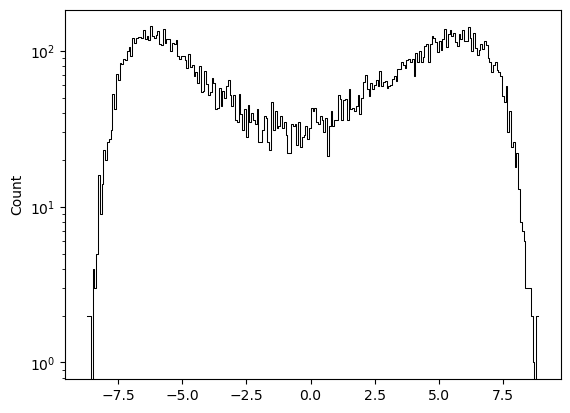

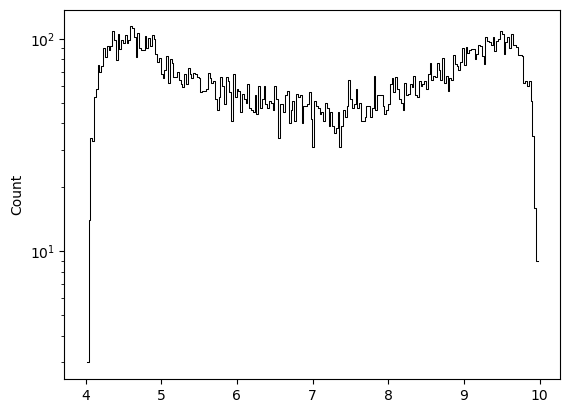

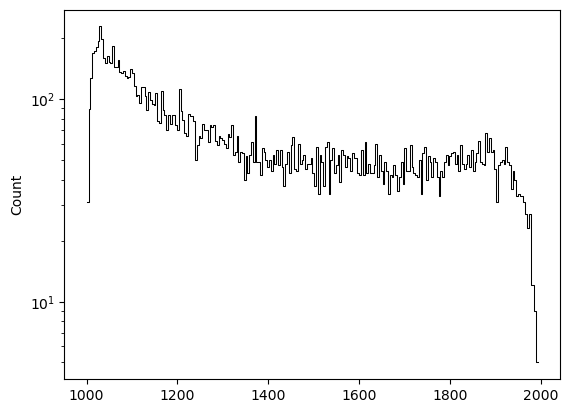

In [11]:
sns.histplot(x=pipeline.target[:,0], color='k', bins=250,log_scale=(False, True), element="step", lw=0.75, fill=False, alpha=1) 
plt.show()
sns.histplot(x=pipeline.target[:,1], color='k', bins=250,log_scale=(False, True), element="step", lw=0.75, fill=False, alpha=1) 
plt.show()
sns.histplot(x=pipeline.target[:,2], color='k', bins=250,log_scale=(False, True), element="step", lw=0.75, fill=False, alpha=1) 
plt.show()

#  TOY DATA: 8 gaussians to 2 moons

#=======================================================================================================================
INFO: created directory: /Users/dario/Dropbox/PROJECTS/ML/DynGenModels/results/MLP.8gauss_to_2moons_2023.09.25_23h06__1
#=======================================================================================================================
+--------------------+------------------+
| Key                | Value            |
+--------------------+------------------+
| data_name          | 8gauss_to_2moons |
| num_samples        | 20000            |
| gaussian_scale     | 5                |
| gaussian_var       | 0.1              |
| moon_noise         | 0.1              |
| features           | ['x', 'y']       |
| device             | cpu              |
| data_split_fracs   | [0.7, 0.2, 0.1]  |
| batch_size         | 256              |
| epochs             | 5000             |
| early_stopping     | 1000             |
| warmup_epochs      | 50               |
| lr    

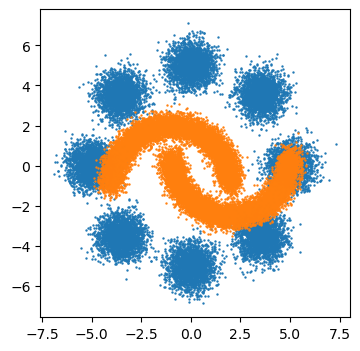

In [12]:
from DynGenModels.models.mlp import MLP
from DynGenModels.configs.toys_configs import ToysMLPConfig

config = ToysMLPConfig(data_name = '8gauss_to_2moons',
                        features = ['x', 'y'],
                        num_samples = 20000,
                        gaussian_scale = 5,
                        gaussian_var = 0.1,
                        moon_noise = 0.1,
                        data_split_fracs = [0.7, 0.2, 0.1],
                        epochs = 5000,
                        early_stopping=1000,
                        batch_size = 256,
                        warmup_epochs = 50,
                        lr = 1e-4,
                        dim_hidden = 64, 
                        device = 'cpu',
                        solver='dopri5',
                        num_sampling_steps=100,
                        seed = 1234
                        )

root_dir =  '/home/df630/' if 'cuda' in config.device else '/Users/dario/Dropbox/PROJECTS/ML/'
root_dir += 'DynGenModels'
config.set_workdir(root_dir + '/results', save_config=True)

mlp = MLP(config)

from DynGenModels.datamodules.toys.datasets import ToysDataset
from DynGenModels.datamodules.toys.dataloader import ToysDataLoader

datasets = ToysDataset(config) 
dataloader = ToysDataLoader(datasets, config)

fig, ax = plt.subplots(1,1, figsize=(4,4))
plt.scatter(datasets.source[:,0], datasets.source[:,1], s=0.5)
plt.scatter(datasets.target[:,0], datasets.target[:,1], s=0.5)
plt.show()

In [13]:
from DynGenModels.trainer.trainer import FlowMatchTrainer
from DynGenModels.dynamics.flowmatch import SimplifiedCondFlowMatching

dynamics = SimplifiedCondFlowMatching(mlp, sigma_min=0.1)

CFM = FlowMatchTrainer(dynamics=dynamics, 
                       dataloader=dataloader,
                       config=config)
CFM.train()

INFO: number of training parameters: 8706


epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

	 test loss: 0.0595391526222229  (min loss: 0.0595391526222229)
	 test loss: 0.05478640913963318  (min loss: 0.0541726667881012)
	 test loss: 0.05346697473526001  (min loss: 0.05295154166221619)
	 test loss: 0.052029385566711425  (min loss: 0.052029385566711425)
	 test loss: 0.050165449619293215  (min loss: 0.050165449619293215)
	 test loss: 0.04732170987129211  (min loss: 0.04732170987129211)
	 test loss: 0.044806811094284055  (min loss: 0.044806811094284055)
	 test loss: 0.04400259041786194  (min loss: 0.04400259041786194)
	 test loss: 0.04352607607841492  (min loss: 0.04293230652809143)
	 test loss: 0.042921160697937014  (min loss: 0.04205081939697266)
	 test loss: 0.04149801802635193  (min loss: 0.04134354996681213)
	 test loss: 0.04206921362876892  (min loss: 0.04134354996681213)
	 test loss: 0.04130209374427796  (min loss: 0.04130209374427796)
	 test loss: 0.040943026542663574  (min loss: 0.040423515319824216)
	 test loss: 0.04094581317901611  (min loss: 0.040423515319824216)
	 t

In [14]:
from DynGenModels.pipelines.FlowMatchPipeline import FlowMatchPipeline
from DynGenModels.datamodules.fermi.dataprocess import PostProcessFermiData


pipeline = FlowMatchPipeline(trained_model=CFM, 
                             postprocessor=None,
                             config=config)

sampling:   0%|          | 0/8 [00:00<?, ?it/s]

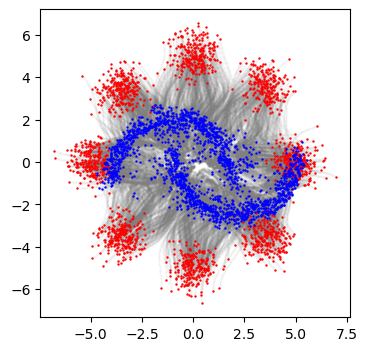

In [34]:

fig, ax = plt.subplots(1,1, figsize=(4,4))
for i in range(100): 
    plt.scatter(pipeline.trajectories[i][:,0], pipeline.trajectories[i][:,1], s=0.1, color='gray', alpha=0.1)
plt.scatter(pipeline.trajectories[0][:,0], pipeline.trajectories[0][:,1], s=0.5, color='red')
plt.scatter(pipeline.trajectories[-1][:,0], pipeline.trajectories[-1][:,1], s=0.5, color='blue')

plt.show()

# DECONVOLUTION

In [20]:
# 3 perpendicular gaussians:

data_means = torch.Tensor([
                    [-2.0, 0.0],
                    [0.0, -2.0],
                    [0.0, 2.0]
                    ])

data_covars = torch.Tensor([
                    [[0.3**2, 0],[0, 1]],
                    [[1, 0],[0, 0.3**2]],
                    [[1, 0],[0, 0.3**2]]
                    ]) 

sigma = torch.Tensor([[0.1, 0], [0, 1]]) 

def plot_data(X, title, save, epoch=False, npoints=20000, xlim=[-10,10], ylim=[-10,10], figsize=(5,5),cmap='jet'):
    x = X[:npoints,0].numpy()
    y = X[:npoints,1].numpy()
    z = stats.gaussian_kde(np.vstack([x,y]))(np.vstack([x,y]))
    fig , ax = plt.subplots(1, 1, figsize=figsize)
    plt.scatter(x, y, s=2, c=z, alpha=0.75, cmap=cmap)
    if epoch: plt.text(4,-9, r'epoch {}'.format(epoch), fontsize=10, wrap=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title)
    fig.tight_layout()
    plt.savefig(save)
    

def gaussian_mix(means=data_means, 
                covars=data_covars, 
                data_size=60000, 
                noise_covariance=torch.Tensor([[1, 0],[0, 1]]),
                dof=3,
                pointwise_noise=False,
                scale_factor=0.15):

    v = torch.distributions.MultivariateNormal(loc=data_means, covariance_matrix=data_covars).sample((data_size,)).reshape((-1, 2))
    idx = torch.randperm(v.shape[0])
    v = v[idx]
    sigma = torch.empty(v.shape[0], 4)
    noise = torch.empty(v.shape)

    for i in range(v.shape[0]): 
        
        if not pointwise_noise: cov = noise_covariance
        elif pointwise_noise=='radial': cov = radial_dependent_covariance(v[i], noise_covariance)
        elif pointwise_noise=='angular': cov = angle_dependent_covariance(v[i], noise_covariance)
        elif pointwise_noise=='mixed': cov = mixed_dependent_covariance(v[i], noise_covariance)
        elif pointwise_noise=='inverse_Wishart': cov = torch.tensor(invwishart.rvs(df=6, scale=noise_covariance, size=1).astype('float32'))
            
        sigma[i] = torch.reshape(cov, (1, 4))
        noise[i] = torch.distributions.MultivariateNormal(loc=torch.Tensor([0.0, 0.0]), covariance_matrix=cov).sample((1,))

    w = torch.zeros(v.shape[0], 6) # concat noise covariance 2x2 matrix to data -> 6=2+(2x2)
    w[:, :2] = v + noise
    w[:, 2:] = sigma

    return v, w

In [23]:
from scipy import stats

v, w = gaussian_mix(data_size=10000, 
                    noise_covariance=sigma, 
                    dof=3,
                    pointwise_noise=False)

NameError: name 'plot_cov' is not defined

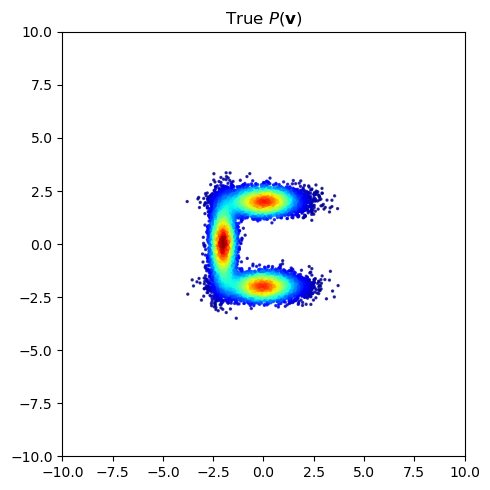

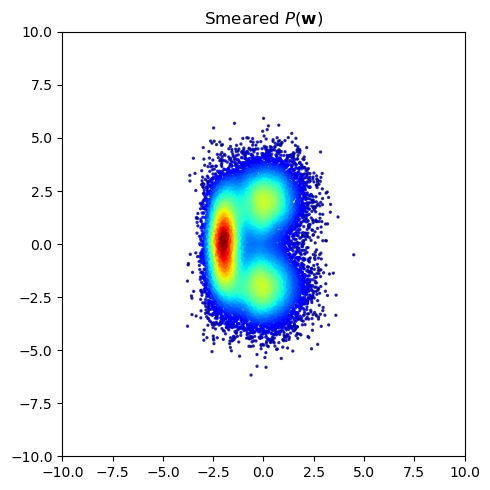

In [24]:
plot_data(v, title=r'True $P(\mathbf{v})$', save= 'truth_data.pdf') 
plot_data(w, title=r'Smeared $P(\mathbf{w})$', save='smeared_data.pdf')
